In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csgraph
import igraph as ig


In [27]:
from importlib import resources

In [28]:
import vmlab

Data analysis on entire trees don't really lead to great results. The independant branches from F14 tree are thus considered, taking into account this time the light environment of the GUs, and if possible the effect of distance.

# Potential variables for explaining fruit growth

### Data

Sunlight fractions : computed from fisheye pictures of the GUs environments on the tree. The mean value on the fruting season is used here (to get only one value for each GU).

In [2]:
with resources.path('vmlab.data.environment', 'fruting_season_sunlit_fractions_F14.csv') as sunlit_fractions_file_path:
    sunlit_fraction_df = pd.read_csv(
            sunlit_fractions_file_path,
            sep='\\s+')
sunlit_fraction_df

,F14_01,F14_02,F14_03,F14_04,F14_05A,F14_05B,F14_06,F14_08A,F14_08B,F14_08C,...,F14_13B,F14_24A,F14_24B,F14_24E,F14_25D,F14_28A,F14_28B,F14_28C,F14_30B,mean
0,0.136813,0.352094,0.191323,0.272562,0.13125,0.16075,0.256937,0.268073,0.294792,0.293052,...,0.115958,0.032958,0.07225,0.061792,0.04724,0.097198,0.036469,0.070813,0.111479,0.219716


Tree chosen for the whole notebook :

In [3]:
tree_name = 'F14'

In [4]:
id = '30'

branch_path = resources.path('vmlab.data.trees', "".join(("branch_", tree_name,"_", id, ".csv")))
branch = pd.read_csv(branch_path)
graph = vmlab.to_graph(branch)
graph_weighted = vmlab.to_weighted_graph(branch)


In [5]:
branch[branch['growth__nb_leaf']!=0]

,id,parent_id,topology__is_apical,arch_dev__pot_flowering_date,arch_dev__pot_nb_inflo,arch_dev__pot_nb_fruit,growth__nb_leaf,growth__radius_gu,appearance__final_length_gu,light_interception__sunlit_fraction_col,environment_id
3,3,2.0,0.0,NaT,NaN,NaN,6,0.565,6,3,F14_30A
4,4,3.0,1.0,NaT,NaN,NaN,7,NaN,10,3,F14_30A
5,5,2.0,0.0,NaT,NaN,NaN,6,0.741,8,3,F14_30A
6,6,5.0,1.0,NaT,NaN,NaN,7,NaN,11,3,F14_30A
7,7,2.0,0.0,NaT,NaN,NaN,1,1.118,6,3,F14_30A
8,8,7.0,1.0,NaT,NaN,NaN,11,NaN,10,3,F14_30A
9,9,8.0,1.0,2002-09-11,1.0,1.0,10,NaN,14,3,F14_30A
10,10,7.0,0.0,NaT,NaN,NaN,7,0.748,6,3,F14_30A
11,11,10.0,1.0,NaT,NaN,NaN,7,NaN,10,3,F14_30A
12,12,2.0,0.0,NaT,NaN,NaN,4,0.361,4,3,F14_30A


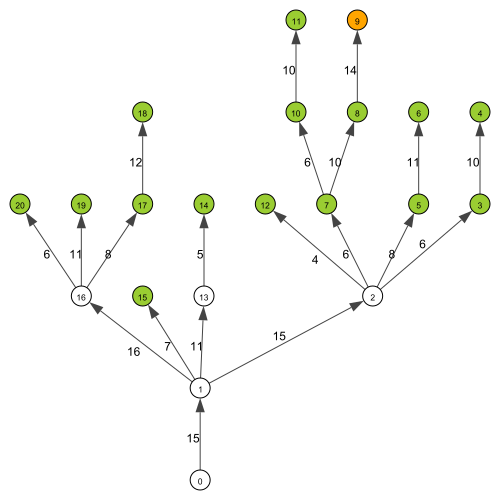

In [9]:
layout = graph_weighted.layout_reingold_tilford()
layout.rotate(-180)
ig.plot(graph_weighted, bbox=(0,0,500,500), 
        layout=layout, 
        vertex_label=graph_weighted.vs.get_attribute_values('id'),
        vertex_label_size = 8.5,
        vertex_color = ['orange' if f>0 else 'yellowgreen' if l>0 else 'white' for f,l in zip(
            graph_weighted.vs.get_attribute_values('arch_dev__pot_nb_fruit'),
            graph_weighted.vs.get_attribute_values('growth__nb_leaf')
        )],
        edge_label = graph_weighted.es['weight'])


Fruits masses for the whole tree :

In [ ]:
with resources.path('vmlab.data.fruit_quality', 'fruits_masses.csv') as path:
    fruit_mass = pd.read_csv(path,
                             sep=",",
                             usecols=[ 'arbre', 'id_UC', 'id_branche', 'id_fruit', 'MS_ini', 'MF_rec'],
                            )
fruit_mass.index=fruit_mass['id_branche']
fruit_mass.drop(columns = ['id_branche'], inplace=True)
fruit_mass = fruit_mass[fruit_mass['arbre']== tree_name ]
#fruit_mass = fruit_mass[fruit_mass.index.notna()]

fruit_mass = fruit_mass.sort_index()

# fruit_mass = fruit_mass.groupby(["id_UC"]).mean("MF_rec")
fruit_mass

,arbre,id_fruit,id_UC,MS_ini,MF_rec
id_branche,,,,,
1.0,F14,1,2.0,10.193409,203.56
2.0,F14,2,2.0,16.448879,234.19
3.0,F14,3,3.0,10.520874,136.01
4.0,F14,4,2.0,9.685426,110.68
5.0,F14,5,4.0,10.904737,287.14
6.0,F14,6,3.0,10.498720,122.94
7.0,F14,7,3.0,9.850146,NaN
8.0,F14,8,5.0,7.588404,379.71
9.0,F14,9,2.0,8.135078,148.25


## Global exploration of the tree

In [11]:
print("Total leaves on the branch :", np.nansum(branch['growth__nb_leaf']))
print("Total fruits on the branch :", np.nansum(branch['arch_dev__pot_nb_fruit']))
print("Number of GUs on the branch: ", graph.ecount())

Total leaves on the branch : 104
Total fruits on the branch : 1.0
Number of GUs on the branch:  20


List of id of growth units bearing fruits on the studied tree :

In [12]:
fruity_GU = np.flatnonzero(branch['arch_dev__pot_nb_fruit'] > 0)
fruity_GU

array([9], dtype=int64)

In [14]:
branch.loc[fruity_GU, 'arch_dev__pot_nb_fruit']

9    1.0
Name: arch_dev__pot_nb_fruit, dtype: float64

## Collecting variables to explain fruit growth

### Fonctions

Topologic distance : the measurement unit is growth units

In [17]:
def get_var_fruit_growth_topo(branch, year_sunlit_fractions) : 

    graph = vmlab.to_graph(branch)
    adjacency = np.array(graph.get_adjacency())

    # Initializaton (setting dtypes)
    distance_to_fruit = np.array([], dtype=np.float32)
    is_in_distance_to_fruit = np.array([], dtype=bool)
    is_fruting = branch['arch_dev__pot_nb_fruit'] > 0

    # Collecting GUs at the chosen distance (with or without successors) from each fruit of the tree :

    if np.any(is_fruting) : 
        distance_to_fruit = csgraph.shortest_path( 
                                    adjacency,
                                    indices=np.flatnonzero(is_fruting),
                                    directed=False
                                    ).astype(np.float32)

    is_in_distance_to_fruit = np.isfinite(distance_to_fruit).astype(np.float32)

    # Collecting fruity and leafy GUs among the previously selected GUs :
    reachable_leaves = is_in_distance_to_fruit.copy()
    reachable_fruits = is_in_distance_to_fruit.copy()
    lit_frac = is_in_distance_to_fruit.copy()

    for i in range (len(np.flatnonzero(is_fruting))):
        reachable_leaves [i,is_in_distance_to_fruit[i]==1] = branch.loc[is_in_distance_to_fruit[i]==1,'growth__nb_leaf']
        reachable_fruits [i,is_in_distance_to_fruit[i]==1] = branch.loc[is_in_distance_to_fruit[i]==1,'arch_dev__pot_nb_fruit'] # the fruit itself is taken into account
        lit_frac [i,is_in_distance_to_fruit[i]==1] = year_sunlit_fractions.loc[:,branch.loc[is_in_distance_to_fruit[i]==1,'environment_id']] 

    # Taking into account the fact that some leaves share their carbon production between several fruits :

    leaf_fruit_sharing_number = np.nansum(np.transpose( 
    np.multiply(
        np.transpose(is_in_distance_to_fruit),                                                # GU bearing fruits to take into account
        np.array(branch.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']) # number of fruits on these GUs                                                 
        )),
    axis=0)

    leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number 
    leaf_fruit_sharing_fraction[leaf_fruit_sharing_fraction==np.inf] = 0 

    assert leaf_fruit_sharing_fraction.all() <= 1
    assert leaf_fruit_sharing_fraction.all() >= 0

    # Computing variables of interest (np.nansum to avoid NA propagation) :
    sum_reachable_leaves = np.nansum(reachable_leaves, axis=1)[0] #nansum to avoid NA propagation

    sum_reachable_leaves_shared = np.nansum(reachable_leaves*leaf_fruit_sharing_fraction, axis=1)[0] #nansum to avoid NA propagation
    available_carbon = np.nansum(lit_frac * reachable_leaves * leaf_fruit_sharing_fraction, axis=1)[0]

    available_carbon_1 = sum_reachable_leaves #/sum_reachable_fruits
    available_carbon_2 = sum_reachable_leaves_shared #/sum_reachable_fruits
    available_carbon_3 = available_carbon #/sum_reachable_fruits
    
    return available_carbon_1, available_carbon_2, available_carbon_3

Geometric distance : the measurement unit is centimeters

In [15]:
def distance_impact_musca (distance, h):
    return 1/((1+distance)**h)

In [83]:
def get_var_fruit_growth_geom(tree: pd.DataFrame, year_sunlit_fractions: pd.DataFrame, h: float, demand: str) : 
    '''
    Returns the carbon available for each GU bearing a fruit in the input tree with different ways of computing it.
    
    Parameters
    ----------
    tree : :class:`pandas.DataFrame` object
        Required format is identical with what is specified for the 'tree' input in the vmlab.create_setup function. A 'environment_id' column is also required.

    year_sunlit_fractions : :class:`pandas.DataFrame` object
        Required format is identical with what is specified for the 'sunlit_fraction_df' input in the vmlab.processes.light_interception initialization.

    h : :class:`float` object
        Friction parameter for mango wood towards carbon flow.

    demand : :class:`str` object
        Type of sink carbon demand in carbon flow computing : 'DM' (dry mass), 'FM' (fresh mass) or '1' (no mass).

    Returns
    -------
    available_carbon1, available_carbon2, available_carbon3, : :class:`numpay.array
    '''

    graph = vmlab.to_weighted_graph(tree)
    adjacency = np.array(graph.get_adjacency(attribute='weight'))

    # Initializaton (setting dtypes)
    distance_to_fruit = np.array([], dtype= float)
    is_fruting = tree['arch_dev__pot_nb_fruit'] > 0

    if np.any(is_fruting) :
        distance_to_fruit = csgraph.shortest_path(
                                    adjacency,
                                    indices=np.flatnonzero(is_fruting),
                                    directed=False,
                                    unweighted = False
                                    ).astype( float)
        
    carbon_flow_raw  = distance_to_fruit.copy()
    carbon_flow_shared  = distance_to_fruit.copy()
    carbon_flow_lit_env  = distance_to_fruit.copy()
    coef_distance = distance_impact_musca(distance_to_fruit, h)

    carbon_sinks = np.copy(coef_distance)
    if demand == 'DM' :
        for j in range (0, len(coef_distance[0])) :
            carbon_sinks[:,j] = coef_distance[:,j] * fruit_mass.loc[np.flatnonzero(is_fruting), 'MS_ini'] * tree.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']
    
    elif demand == 'FM' :
        for j in range (0, len(coef_distance[0])) :
            carbon_sinks[:,j] = coef_distance[:,j] * fruit_mass.loc[np.flatnonzero(is_fruting), 'MF_rec'] * tree.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']

    else :
        for j in range (0, len(coef_distance[0])) :
            carbon_sinks[:,j] = coef_distance[:,j] * tree.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']

    for j in range (0, len(distance_to_fruit)):
        carbon_flow_raw[j] = (coef_distance[j] * tree["growth__nb_leaf"]) #envoi de carbone sans limitation 
        carbon_flow_shared[j] = (carbon_sinks[j] * tree["growth__nb_leaf"]  ) / np.nansum(carbon_sinks, axis=0) # envoi d'autant de carbone que disponible dans les feuilles
        carbon_flow_lit_env[j] = (carbon_sinks[j] * tree["growth__nb_leaf"] * year_sunlit_fractions[tree["environment_id"]].to_numpy()[0] ) / np.nansum(carbon_sinks, axis=0) # envoi d'autant de carbone que disponible dans les feuilles selon la capacité de photosynthèse

    available_carbon_raw = np.round(np.nansum(carbon_flow_raw, axis=1), decimals=2)
    available_carbon_shared = np.round(np.nansum(carbon_flow_shared, axis=1), decimals=2)
    available_carbon_lit_env = np.round(np.nansum(carbon_flow_lit_env, axis=1), decimals=2)

    return available_carbon_raw, available_carbon_shared, available_carbon_lit_env

### Results

In [ ]:
example = pd.DataFrame(get_var_fruit_growth_topo(branch, sunlit_fraction_df), columns=[id], index=["LF leaves", "LF sharing", "LF light env"])
example

,30
LF leaves,104.000000
LF sharing,104.000000
LF light env,28.518833


In [56]:
h=0.4

In [57]:
coef = np.round(distance_impact_musca(csgraph.shortest_path(np.array(graph_weighted.get_adjacency(attribute='weight')),
                                                indices = np.flatnonzero(branch['arch_dev__pot_nb_fruit'] > 0),
                                                directed= False,
                                                unweighted = False).astype(np.float32), 
                                                h=h), decimals=2)
coef

array([[0.19, 0.22, 0.25, 0.24, 0.21, 0.23, 0.21, 0.28, 0.34, 1.  , 0.25,
        0.23, 0.24, 0.2 , 0.19, 0.2 , 0.19, 0.18, 0.17, 0.18, 0.18]],
      dtype=float32)

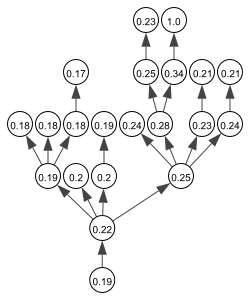

In [58]:
layout = graph_weighted.layout_reingold_tilford()
layout.rotate(180)
ig.plot(
    graph_weighted, 
    bbox=(0,0,250,300), 
    layout=layout,
    vertex_label = coef[0],
    vertex_size = 25,
    vertex_label_size = 10,
    vertex_color="white")

In [84]:
example2 = pd.DataFrame(get_var_fruit_growth_geom(branch, sunlit_fraction_df, h=h, demand='1'), columns=[id], index=["LF leaves", "LF sharing", "LF light env"])
example2

,30
LF leaves,31.03
LF sharing,104.00
LF light env,28.52


In [ ]:
# collecting variables at the distance dmax :
branch_names = ['01','02','03','04','05','06','08','09','10','11','12','13','14','15','16','17','19','20','21','23','24','25','26','27','28','29','30']
branches = ["".join(("branch_F14_",id,".csv")) for id in  branch_names]
results = [ get_var_fruit_growth_topo(pd.read_csv(resources.path('vmlab.data.trees', name)),sunlit_fraction_df) for name in branches ]

# results are fitted into a dataframe :
final_table = pd.DataFrame(results, index=[1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,19,20,21,23,24,25,26,27,28,29,30], columns=["carbon_raw", "carbon_shared", "carbon_lit_env"])

final_table['tree'] = np.full(fill_value = tree_name, shape = len(final_table.index))

# final_table["fresh_mass"] = fruit_mass['MF_rec']
# final_table["dry_mass"] = fruit_mass["MS_ini"]

final_table


,carbon_raw,carbon_shared,carbon_lit_env,tree
1,40.0,40.0,6.550243,F14
2,22.0,22.0,7.746063,F14
3,26.0,26.0,4.974396,F14
4,16.0,16.0,5.633500,F14
5,77.0,77.0,8.022416,F14
6,14.0,14.0,3.597125,F14
8,66.0,66.0,18.982406,F14
9,24.0,24.0,5.325500,F14
10,56.0,56.0,10.782041,F14
11,34.0,34.0,9.905334,F14


In [109]:
with resources.path('vmlab.data.results', 'Exploration_F14_fruting_season_topo.csv') as path:
    final_table.to_csv(path_or_buf= path)

_Conclusion :_

In topologic distances, on R, taking into account the light environment increase the good-fitness of the model.

In geometric distances, no more results are obtained because each GU only contributes to one fruit (construction of the exepriment on F14). Or the friction f only makes occurs to distirbute carbon between several fruits.